In [26]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import glob
import math
import os

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

df_train = pd.read_csv("../train.csv", sep = ",")
df_test = pd.read_csv("../test.csv", sep = ",")
df_sample = pd.read_csv('../sample_submission.csv', sep = ",")

df_train = df_train.reindex(np.random.permutation(df_train.index))

df_test = df_test / 255


1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

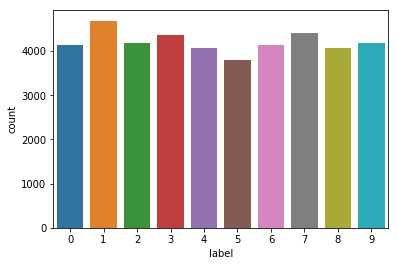

In [27]:
Y_train = df_train["label"]
g = sns.countplot(Y_train)
Y_train.value_counts()

In [28]:
df_test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [29]:
def parse_labels_and_features(dataset):
    labels = dataset.iloc[:,0]
    features = dataset.iloc[:,1:785]
    features = features / 255
    return features.values, labels.values,

In [30]:
train_data, train_labels = parse_labels_and_features(df_train.head(32000))
train_labels = np.asarray(train_labels, dtype=np.int32)


In [31]:
eval_data, eval_labels = parse_labels_and_features(df_train.tail(10000))
eval_labels = np.asarray(eval_labels, dtype=np.int32)


In [32]:
# Training Parameters
learning_rate = 0.001
num_steps = 200
batch_size = 128

# Network Parameters
num_input = 784 # MNIST data input (img shape: 28*28)
num_classes = 10 # MNIST total classes (0-9 digits)
dropout = 0.25 # Dropout, probability to drop a unit

In [33]:
# Create the neural network
def conv_net(x_dict, n_classes, dropout, reuse, is_training):
    # Define a scope for reusing the variables
    with tf.variable_scope('ConvNet', reuse=reuse):
        # TF Estimator input is a dict, in case of multiple inputs
        x = x_dict['images']

        # MNIST data input is a 1-D vector of 784 features (28*28 pixels)
        # Reshape to match picture format [Height x Width x Channel]
        # Tensor input become 4-D: [Batch Size, Height, Width, Channel]
        x = tf.reshape(x, shape=[-1, 28, 28, 1])

        # Convolution Layer with 32 filters and a kernel size of 5
        conv1 = tf.layers.conv2d(x, 32, 5, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        conv1 = tf.layers.max_pooling2d(conv1, 2, 2)

        # Convolution Layer with 64 filters and a kernel size of 3
        conv2 = tf.layers.conv2d(conv1, 64, 3, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        conv2 = tf.layers.max_pooling2d(conv2, 2, 2)

        # Flatten the data to a 1-D vector for the fully connected layer
        fc1 = tf.contrib.layers.flatten(conv2)

        # Fully connected layer (in tf contrib folder for now)
        fc1 = tf.layers.dense(fc1, 1024)
        # Apply Dropout (if is_training is False, dropout is not applied)
        fc1 = tf.layers.dropout(fc1, rate=dropout, training=is_training)

        # Output layer, class prediction
        out = tf.layers.dense(fc1, n_classes)

    return out


In [34]:
# Define the model function (following TF Estimator Template)
def model_fn(features, labels, mode):
    # Build the neural network
    # Because Dropout have different behavior at training and prediction time, we
    # need to create 2 distinct computation graphs that still share the same weights.
    logits_train = conv_net(features, num_classes, dropout, reuse=False,
                            is_training=True)
    logits_test = conv_net(features, num_classes, dropout, reuse=True,
                           is_training=False)

    # Predictions
    pred_classes = tf.argmax(logits_test, axis=1)
    pred_probas = tf.nn.softmax(logits_test)

    # If prediction mode, early return
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions=pred_classes)

        # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits_train, labels=tf.cast(labels, dtype=tf.int32)))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op,
                                  global_step=tf.train.get_global_step())

    # Evaluate the accuracy of the model
    acc_op = tf.metrics.accuracy(labels=labels, predictions=pred_classes)

    # TF Estimators requires to return a EstimatorSpec, that specify
    # the different ops for training, evaluating, ...
    estim_specs = tf.estimator.EstimatorSpec(
        mode=mode,
        predictions=pred_classes,
        loss=loss_op,
        train_op=train_op,
        eval_metric_ops={'accuracy': acc_op})

    return estim_specs

In [35]:
def train_cnn_classification_model(
    learning_rate,
    steps,
    batch_size,
    train_data,
    train_labels,
    eval_data,
    eval_labels):

        # Build the Estimator
    model = tf.estimator.Estimator(model_fn, model_dir="./Savemodel")

    # Define the input function for training
    input_fn = tf.estimator.inputs.numpy_input_fn(
        x={'images': train_data}, y=train_labels,
        batch_size=batch_size, num_epochs=None, shuffle=True)

    # Define the input function for evaluating
    eval_input_fn = tf.estimator.inputs.numpy_input_fn(
        x={'images': eval_data}, y=eval_labels,
        batch_size=batch_size, shuffle=False)
    
    predict_input_fn = tf.estimator.inputs.numpy_input_fn(
        x = {'images': train_data},
        batch_size=batch_size,
        shuffle=False)

    predict_eval_input_fn = tf.estimator.inputs.numpy_input_fn(
        x = {'images': eval_data},
        batch_size=batch_size,
        shuffle=False)
    # Create feature columns.
    feature_columns = [tf.feature_column.numeric_column('pixels', shape=784)]

    # Train the model, but do so inside a loop so that we can periodically assess
    # loss metrics.
    periods = 10
    print("Training model...")
    print("LogLoss error (on validation data):")
    training_errors = []
    validation_errors = []
    for period in range (0, periods):
        # Train the model, starting from the prior state.
        model.train(input_fn, steps=steps)

        train_pred = model.predict(predict_input_fn)
        eval_pred = model.predict(predict_eval_input_fn)
        train_pred = np.array([item for item in train_pred])
        eval_pred  = np.array([item for item in eval_pred])


        training_pred_one_hot = tf.keras.utils.to_categorical(train_pred,10)
        validation_pred_one_hot = tf.keras.utils.to_categorical(eval_pred,10)    

        training_log_loss = metrics.log_loss(train_labels, training_pred_one_hot)
        validation_log_loss = metrics.log_loss(eval_labels, validation_pred_one_hot)
        # Occasionally print the current loss.
        print("  period %02d : %0.2f" % (period, validation_log_loss))
        # Add the loss metrics from this period to our list.
        training_errors.append(training_log_loss)
        validation_errors.append(validation_log_loss)

    print("Model training finished.")
    # Calculate final predictions (not probabilities, as above).
    final_predictions = model.predict(input_fn=predict_eval_input_fn)
    final_predictions = np.array([item for item in final_predictions])


    accuracy = metrics.accuracy_score(eval_labels, final_predictions)
    print("Final accuracy (on validation data): %0.2f" % accuracy)

    # Output a graph of loss metrics over periods.
    plt.ylabel("LogLoss")
    plt.xlabel("Periods")
    plt.title("LogLoss vs. Periods")
    plt.plot(training_errors, label="training")
    plt.plot(validation_errors, label="validation")
    plt.legend()
    plt.show()
    return model

Training model...
LogLoss error (on validation data):
  period 00 : 0.52
  period 01 : 0.43
  period 02 : 0.44
  period 03 : 0.42
  period 04 : 0.38
  period 05 : 0.32
  period 06 : 0.32
  period 07 : 0.32
  period 08 : 0.32
  period 09 : 0.32
Model training finished.
Final accuracy (on validation data): 0.99


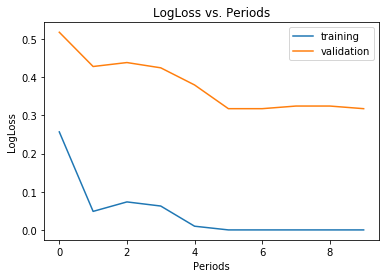

In [36]:
classifier = train_cnn_classification_model(
    learning_rate=.005,
    steps=1000,
    batch_size=300,
    train_data=train_data,
    train_labels=train_labels,
    eval_data=eval_data,
    eval_labels=eval_labels)

In [37]:
# # Build the Estimator
# model = tf.estimator.Estimator(model_fn)

# # Define the input function for training
# input_fn = tf.estimator.inputs.numpy_input_fn(
#     x={'images': train_data}, y=train_labels,
#     batch_size=batch_size, num_epochs=None, shuffle=True)

# # Define the input function for evaluating
# eval_input_fn = tf.estimator.inputs.numpy_input_fn(
#     x={'images': eval_data}, y=eval_labels,
#     batch_size=batch_size, shuffle=False)

# predict_input_fn = tf.estimator.inputs.numpy_input_fn(
#     x = {'images': train_data},
#     batch_size=batch_size,
#     shuffle=False)
    
# predict_eval_input_fn = tf.estimator.inputs.numpy_input_fn(
#     x = {'images': eval_data},
#     batch_size=batch_size,
#     shuffle=False)

# # Train the Model
# periods = 10
# steps = num_steps / periods
# print("Training model...")
# print("LogLoss error (on validation data):")
# training_errors = []
# validation_errors = []
# for period in range (0, periods):
#     # Train the model, starting from the prior state.
#     model.train(input_fn, steps=steps)
    
#     train_pred = model.predict(predict_input_fn)
#     eval_pred = model.predict(predict_eval_input_fn)
#     train_pred = np.array([item for item in train_pred])
#     eval_pred  = np.array([item for item in eval_pred])

        
#     training_pred_one_hot = tf.keras.utils.to_categorical(train_pred,10)
#     validation_pred_one_hot = tf.keras.utils.to_categorical(eval_pred,10)    

#     training_log_loss = metrics.log_loss(train_labels, training_pred_one_hot)
#     validation_log_loss = metrics.log_loss(eval_labels, validation_pred_one_hot)
#     # Occasionally print the current loss.
#     print("  period %02d : %0.2f" % (period, validation_log_loss))
#     # Add the loss metrics from this period to our list.
#     training_errors.append(training_log_loss)
#     validation_errors.append(validation_log_loss)

# print("Model training finished.")
# # Calculate final predictions (not probabilities, as above).
# final_predictions = model.predict(input_fn=predict_eval_input_fn)
# final_predictions = np.array([item for item in final_predictions])


# accuracy = metrics.accuracy_score(eval_labels, final_predictions)
# print("Final accuracy (on validation data): %0.2f" % accuracy)

# # Output a graph of loss metrics over periods.
# plt.ylabel("LogLoss")
# plt.xlabel("Periods")
# plt.title("LogLoss vs. Periods")
# plt.plot(training_errors, label="training")
# plt.plot(validation_errors, label="validation")
# plt.legend()
# plt.show()

In [38]:
# sample_data, sample_labels = parse_labels_and_features(df_sample)
# sample_labels = np.asarray(sample_labels, dtype=np.int32)
# df_test = np.asarray(df_test, dtype=np.float64)

In [39]:
# model = train_cnn_classification_model

# # Define the input function for evaluating
# test_input_fn = tf.estimator.inputs.numpy_input_fn(
#     x = {'images': df_test},
#     y=sample_labels,
#     batch_size=batch_size,
#     shuffle=False
# )

# test_predictions = model.predict(test_input_fn)
# test_predictions = np.array([item for item in test_predictions])

# test_predictions

In [40]:
# my_submission = pd.DataFrame({'ImageId': df_sample.ImageId, 'Label': test_predictions})
# # you could use any filename. We choose submission here
# my_submission.to_csv('submission6.csv', index=False)
